In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import botbacktester as bbt
import botbacktester.enums as E

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("data/gmo_btc_jpy_1min.csv")
df['timestamp'] = pd.to_datetime(df.timestamp)
df = df.set_index("timestamp")

In [3]:
short_period = 14
long_period = 28

df['ema_short'] = df.ewm(short_period, min_periods=short_period).close.mean()
df['ema_long'] = df.ewm(long_period, min_periods=long_period).close.mean()
df['ema_short_long_position'] = np.where(df.ema_short > df.ema_long, 1, -1)
df['ema_golden_cross'] = np.where((df.ema_short_long_position == 1) & (df.ema_short_long_position.shift(1) == -1), 1, 0)
df['ema_dead_cross'] = np.where((df.ema_short_long_position == -1) & (df.ema_short_long_position.shift(1) == 1), 1, 0)

df = df.dropna()

In [4]:
df[['ema_short', 'ema_long', 'ema_short_long_position', 'ema_golden_cross', 'ema_dead_cross']]

,ema_short,ema_long,ema_short_long_position,ema_golden_cross,ema_dead_cross
timestamp,,,,,
2021-04-16 21:27:00,6.759009e+06,6.759640e+06,-1,0,0
2021-04-16 21:28:00,6.757975e+06,6.758882e+06,-1,0,0
2021-04-16 21:29:00,6.757126e+06,6.758244e+06,-1,0,0
2021-04-16 21:30:00,6.756773e+06,6.757944e+06,-1,0,0
2021-04-16 21:31:00,6.756641e+06,6.757794e+06,-1,0,0
...,...,...,...,...,...
2021-04-26 20:55:00,5.781546e+06,5.794038e+06,-1,0,0
2021-04-26 20:56:00,5.781084e+06,5.793369e+06,-1,0,0
2021-04-26 20:57:00,5.780083e+06,5.792427e+06,-1,0,0


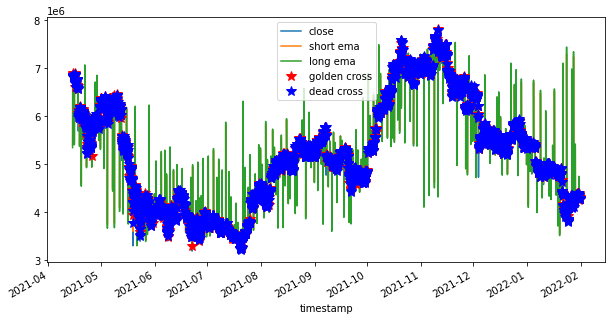

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

df.close.plot()
df.ema_short.plot(label="short ema")
df.ema_long.plot(label="long ema")

df[df.ema_golden_cross == 1].close.plot(linewidth=0, marker="*", markersize=10, color="red", label="golden cross")
df[df.ema_dead_cross == 1].close.plot(linewidth=0, marker="*", markersize=10, color="blue", label="dead cross")

plt.legend()
plt.show()

In [ ]:
tester = bbt.BackTester(df)

In [ ]:
for i, item in tester.start():
    positions = tester.positions()

    if item['ema_golden_cross'] == 1:
        if len(positions) > 0:
            assert len(positions) == 1
            p = positions[0]
            # assert p.side == E.Side.SELL
            tester.exit(p, E.ExecutionType.MARKET)

        tester.entry(E.Side.BUY, E.ExecutionType.MARKET)

    elif item['ema_dead_cross'] == 1:
        if len(positions) > 0:
            assert len(positions) == 1
            p = positions[0]
            # assert p.side == E.Side.BUY
            tester.exit(p, E.ExecutionType.MARKET)

        tester.entry(E.Side.SELL, E.ExecutionType.MARKET)


In [ ]:
df_result = tester.get_result_df()

In [ ]:
bbt.evaluate.report(df_result)